In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-clothing-store/products_skus.csv
/kaggle/input/ecommerce-clothing-store/products.csv
/kaggle/input/ecommerce-clothing-store/traffic.csv
/kaggle/input/ecommerce-clothing-store/orders_items.csv
/kaggle/input/ecommerce-clothing-store/orders.csv
/kaggle/input/ecommerce-clothing-store/customers.csv
/kaggle/input/ecommerce-clothing-store/transactions.csv


In [3]:
# The dataset of this project is from an online store, which includes product information and
# customer transaction records from 2016 to 2018. The ultimate goal of the company is to
# improve the sales. In this project, you’re supposed to find out the online shopping behaviors of
# the customers and make marketing suggestions for the store in order to increase the
# customers’ life-time value to the company.

In [4]:
customers = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/customers.csv') 
traffic = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/traffic.csv').drop(columns=['index'])
products = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products.csv')
prod_sku = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products_skus.csv')
orders = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders.csv')
ord_item = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders_items.csv')
transactions = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/transactions.csv')

In [5]:
# customer => website (traffic) => product/product sku => order/order items => transaction

### 1. How’s the trend of website traffic and the number of orders over time? 
- Is there any correlation between the orders and the website traffic?

<AxesSubplot:xlabel='date_day', ylabel='page_views'>

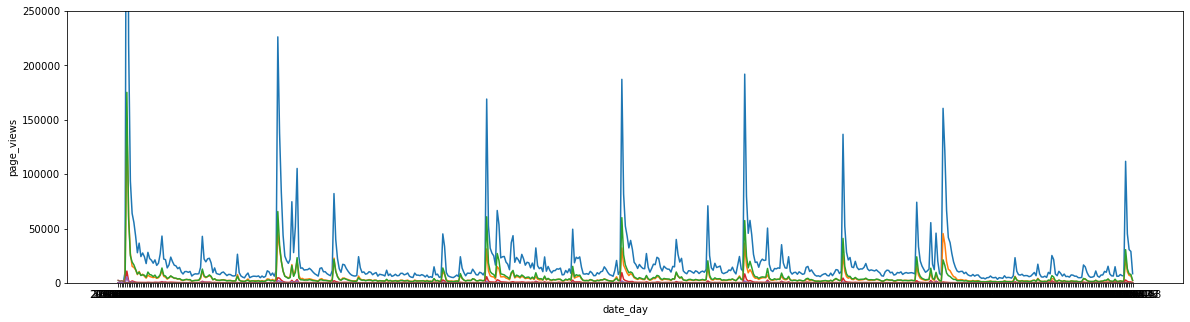

In [6]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
plt.figure(figsize=(20, 5))
plt.ylim((0, 250000))
# pageview - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='page_views')
# sessions - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='sessions')
# prduct detail view - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_detail_views')
# product add to cart - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_adds_to_carts')
# product checkouts - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_checkouts')
# avg session s - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='avg_session_in_s')

<AxesSubplot:xlabel='created_at', ylabel='num_order_created'>

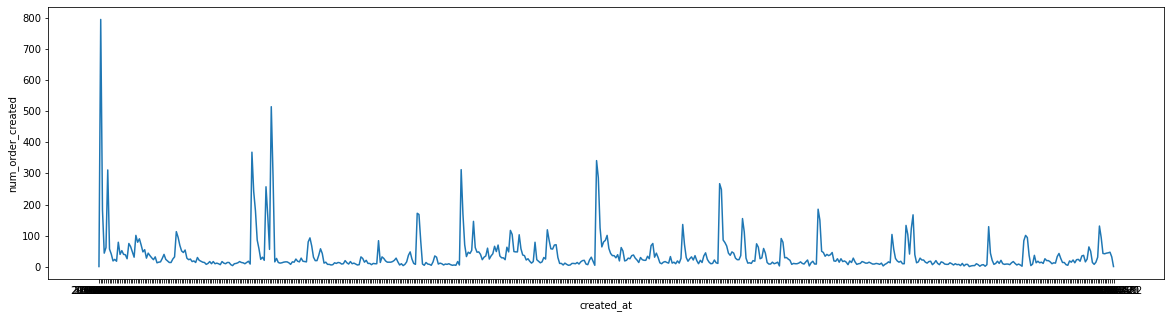

In [7]:
# order - time
order_by_time = orders.groupby(['created_at'])['id'].nunique().reset_index().rename(columns={'id':'num_order_created'})
order_by_time_no_can = orders.loc[lambda x: x['cancelled_at'].isnull()].groupby(['created_at'])['id'].nunique().reset_index().rename(columns={'id':'num_order_created'})

plt.figure(figsize=(20, 5))
sns.lineplot(data=order_by_time, x='created_at', y='num_order_created')

Text(0, 0.5, 'product_checkouts (no cancellation)')

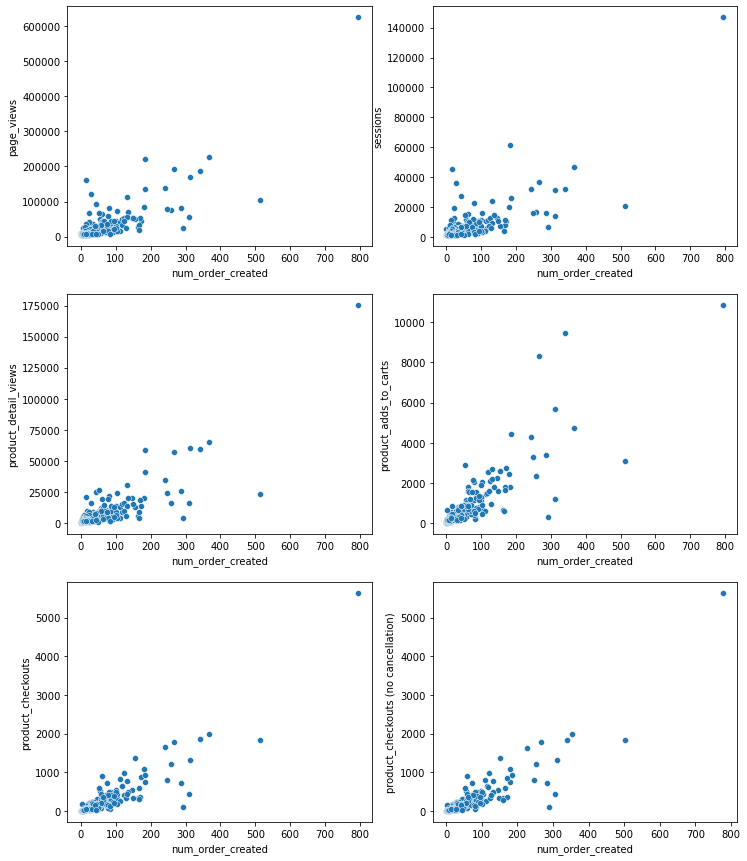

In [8]:
cor_traf_time = traffic.merge(order_by_time, 
                              left_on='date_day',
                              right_on='created_at').sort_values(by=['date_day'])
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
sns.scatterplot(data=cor_traf_time, y='page_views', x='num_order_created', ax=ax1)
sns.scatterplot(data=cor_traf_time, y='sessions', x='num_order_created', ax=ax2)
sns.scatterplot(data=cor_traf_time, y='product_detail_views', x='num_order_created', ax=ax3)
sns.scatterplot(data=cor_traf_time, y='product_adds_to_carts', x='num_order_created', ax=ax4)
sns.scatterplot(data=cor_traf_time, y='product_checkouts', x='num_order_created', ax=ax5)

cor_traf_time_no_can = traffic.merge(order_by_time_no_can, 
                                     left_on='date_day',
                                     right_on='created_at').sort_values(by=['date_day'])
sns.scatterplot(data=cor_traf_time_no_can, y='product_checkouts', x='num_order_created', ax=ax6)
ax6.set_ylabel('product_checkouts (no cancellation)')

In [9]:
# 2. How’s the sales from the different products over the seasons or months? What are the popular products? Is there any correlation between different products?


In [10]:
prod_order = pd.merge(ord_item[['order_id', 'product_id', 'price', 'quantity']],
         products[['id', 'product_type', 'created_at','published_at']].rename(columns={'id':'product_id', 'created_at':'prod_created_at'}),
         on='product_id').merge(orders[['id', 'created_at', 'closed_at', 'cancelled_at', 'total_line_items_price']].rename(columns={'id':'order_id', 'created_at':'ord_created_at', 'closed_at':'ord_closed_at', 'cancelled_at':'ord_cancelled_at'}), on='order_id').sort_values(by=['order_id', 'product_id'])
prod_order

,order_id,product_id,price,quantity,product_type,prod_created_at,published_at,ord_created_at,ord_closed_at,ord_cancelled_at,total_line_items_price
0,7675398239,1.292763e+10,35.0,1,Tunic,2016-08-18,NaN,2016-08-21,2016-08-25,2016-08-22,35.0
663,7676331935,1.292763e+10,35.0,1,Tunic,2016-08-18,NaN,2016-08-22,2016-08-22,NaN,114.0
664,7676331935,1.292763e+10,79.0,1,Bomber,2016-08-18,2016-08-18,2016-08-22,2016-08-22,NaN,114.0
2877,7676363167,1.292763e+10,25.0,1,Shirts,2016-08-18,2018-02-05,2016-08-22,NaN,2016-08-22,83.0
2876,7676363167,1.292806e+10,58.0,1,Trousers,2016-08-18,2016-08-18,2016-08-22,NaN,2016-08-22,83.0
...,...,...,...,...,...,...,...,...,...,...,...
35823,940287628797,1.183022e+12,98.0,1,Blazer,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.0
35824,940287628797,1.183022e+12,62.0,1,Pants,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.0
35822,940287628797,1.183022e+12,65.0,1,Pants,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.0
35825,940287628797,1.183022e+12,79.0,1,Jacket,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.0


In [11]:
print('Total No. product types =', prod_order['product_type'].nunique())
prod_by_t = pd.pivot_table(prod_order,
               index='ord_created_at',
               columns='product_type',
               values='quantity',
               aggfunc=lambda x: sum(x),
               fill_value=0).reset_index().sort_values(by=['ord_created_at'])
prod_by_t.columns = [col.lower().replace(' ', '_') for col in prod_by_t.columns]
prod_by_t

Total No. product types = 28


,ord_created_at,accessory,blazer,blouse,bodysuit,bomber,cardigan,dress,gift_card,hooide,...,top,tousers,trousers,tunic,crop_top,hoodie,maxi,midi,mini,romper
0,2016-08-21,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2016-08-22,0,74,84,39,48,28,95,0,126,...,84,46,65,200,0,0,0,0,0,0
2,2016-08-23,0,19,12,9,30,0,32,0,1,...,17,20,13,41,0,0,0,0,0,0
3,2016-08-24,0,6,3,2,5,0,5,0,0,...,3,6,4,4,0,0,0,0,0,0
4,2016-08-25,0,5,5,1,2,0,10,0,12,...,0,2,0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,2018-03-18,9,2,5,0,1,0,9,0,0,...,7,0,1,0,1,1,4,1,14,0
574,2018-03-19,0,0,4,0,0,1,6,0,0,...,7,0,0,0,4,0,8,4,5,0
575,2018-03-20,1,2,6,0,0,0,7,0,0,...,3,0,1,0,4,1,8,0,11,0
576,2018-03-21,1,1,3,0,0,0,3,0,3,...,5,0,2,0,1,1,4,1,7,0


Here we will start with top6 most bought product types to see the sales seasonal trends.
Top6: ['top', 'dress', 'shirts', 'trousers', 'hoodie', 'sweater']


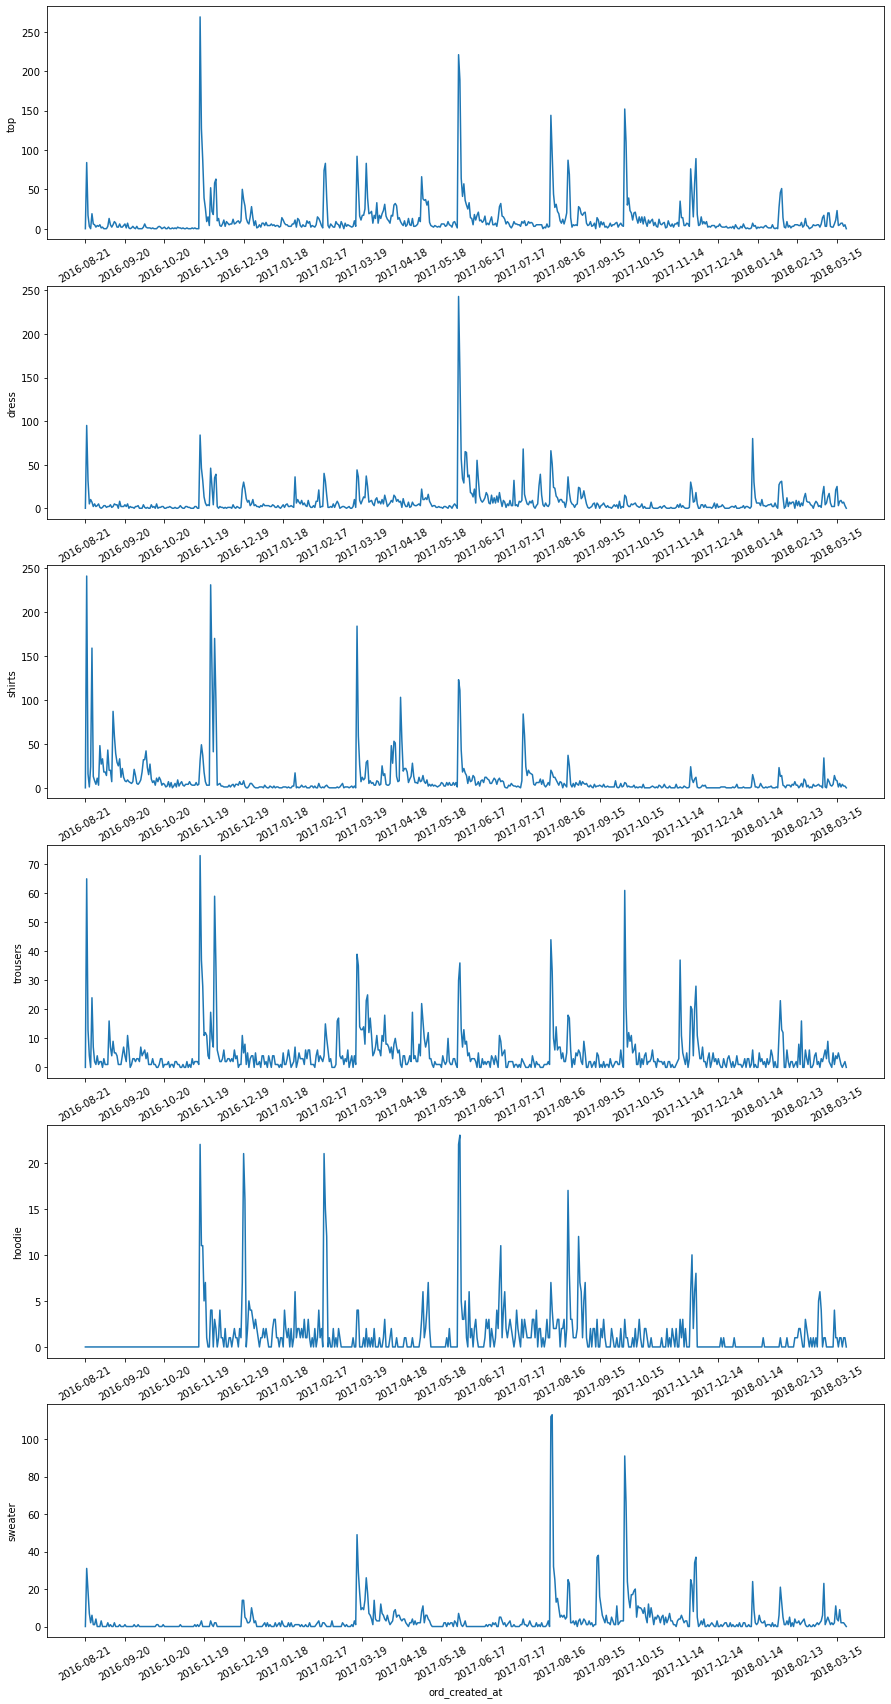

In [24]:
print('Here we will start with top6 most bought product types to see the sales seasonal trends.')
top6_prod_type_list = ['top', 'dress', 'shirts', 'trousers', 'hoodie', 'sweater']
print('Top6:', top6_prod_type_list)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(15, 30))
ind_list = np.arange(0, 577, 30)
for ax, col in zip((ax1, ax2, ax3, ax4, ax5, ax6), top6_prod_type_list):
    sns.lineplot(data=prod_by_t, x='ord_created_at', y=col, ax=ax)
    ax.set_xticks(ind_list)
    ax.set_xticklabels(labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=30)
#plt.xticks(ticks=ind_list, labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=30);

<AxesSubplot:>

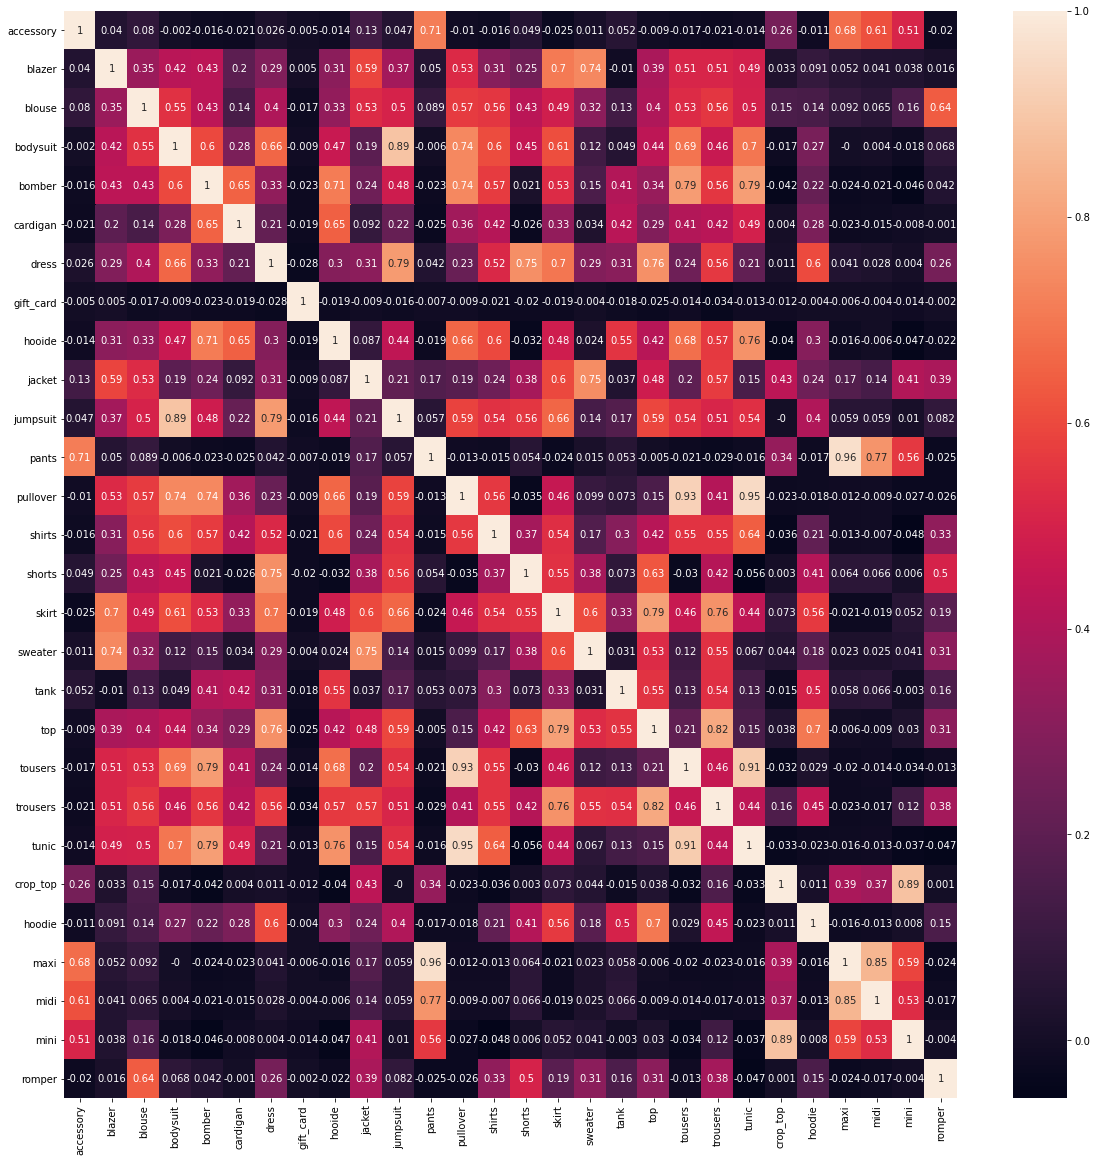

In [36]:
plt.figure(figsize=(20, 20))
sns.heatmap(np.round(prod_by_t.drop(columns=['ord_created_at']).corr(), 3), annot=True);

In [14]:
# 3. How’s the sales of different products with discount? Does the discount promote sales?


In [15]:
# 4. Dig more into the data and gain more insights, you can choose some E-commerce metrics or analysis (e.g. churn rate, conversion rate, retention rate, RFM analysis). 

In [16]:
# 5. Based on the insights from all above questions, do you have any suggestion for the growth of sales?